In [1]:
import sys        
sys.path.append('/home/huyentn2/project/nano_count/segmentation_unet/')

from dataset import *
from utils import *
import torch.nn.functional  as F
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from scipy.ndimage import label
from utils import get_num_NP
import matplotlib.pyplot as plt


/home/huyentn2/.conda/envs/nano/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=1, n_classes= 2, bilinear= False)
model = model.to(memory_format=torch.channels_last)
model = torch.nn.DataParallel(model).cuda()

checkpoint = torch.load("/home/huyentn2/project/nano_count/segmentation_unet/checkpoints_7_4/fold9/checkpoint_epoch15.pth")

model.load_state_dict(checkpoint)
model.to(device=device)

input_dir = "/home/huyentn2/project/nano_count/segmentation_unet/data/img_patch/Tianle1ng_0208_3.png"
save_dir = "/home/huyentn2/project/nano_count/segmentation_unet"


mask_pred = eval_single_count(input_dir,
            save_dir,
            model,
            device,
            img_scale=1.0,
            )

In [3]:
min_dist = 10
max_fil_thr = 120
bin_thr = 0.5
range_rad = (10,200)
type_count = "2"

In [4]:
get_num_NP(mask_pred, min_dist, max_fil_thr, bin_thr,  range_rad, type_count)

/home/huyentn2/.conda/envs/nano/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


36

tensor(0.7402)

DRAFT TO GET THE COUNTS

In [2]:
# import torch
# from PIL import Image
# from pathlib import Path
# from tqdm import tqdm
# from torch.utils.data import DataLoader, random_split
# import torch.nn.functional  as F
# import matplotlib.pyplot as plt
# import os

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=1, n_classes= 2, bilinear= False)
model = model.to(memory_format=torch.channels_last)
model = torch.nn.DataParallel(model).cuda()

checkpoint = torch.load("/home/huyentn2/project/nano_count/segmentation_unet/checkpoints_7_4/fold9/checkpoint_epoch15.pth")

model.load_state_dict(checkpoint)
model.to(device=device)

In [4]:
input_dir = "/home/huyentn2/project/nano_count/segmentation_unet/data/img_patch/Tianle1ng_0208_3.png"
save_dir = "/home/huyentn2/project/nano_count/segmentation_unet"

In [5]:
mask_pred = eval_single_count(input_dir,
            save_dir,
            model,
            device,
            img_scale=1.0,
            )

In [6]:
mask_pred.shape
mask_pred = mask_pred.cpu()
mask_soft = F.one_hot(mask_pred.argmax(dim=1), model.module.n_classes).permute(0, 3, 1, 2).float().squeeze().numpy()

bin_thr = 0.5
mask_pred_0 = F.sigmoid(mask_pred).squeeze()[0,:].float()
mask_pred_0 = torch.where(mask_pred_0> bin_thr, 1, 0).numpy()

mask_pred_1 = F.sigmoid(mask_pred).squeeze()[1,:].float()
mask_pred_1 = torch.where(mask_pred_1> bin_thr, 1, 0).numpy()


torch.Size([1, 2, 600, 960])

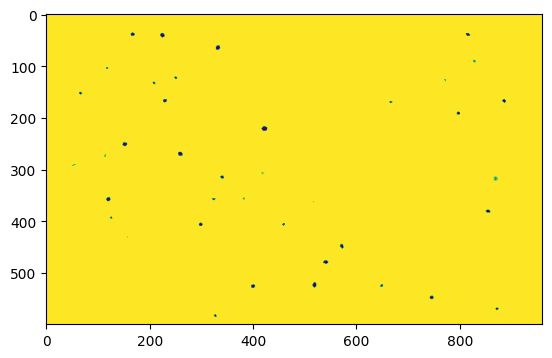

In [10]:
import matplotlib.pyplot as plt
plt.imshow(mask_pred_0)

In [11]:
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

im = F.sigmoid(mask_pred).squeeze()[1,:].numpy()
min_dist = 10
thr = 120


image_max = ndi.maximum_filter(im, size=5, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(im*255, min_distance=min_dist, threshold_abs=thr)

print(len(coordinates))

52


/home/huyentn2/.conda/envs/nano/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [12]:
im = (1-F.sigmoid(mask_pred)).squeeze()[0,:].numpy()
min_dist = 10
thr = 120


image_max = ndi.maximum_filter(im, size=5, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(im*255, min_distance=min_dist, threshold_abs=thr)

print(len(coordinates))

44


Not use local maximum filter

44


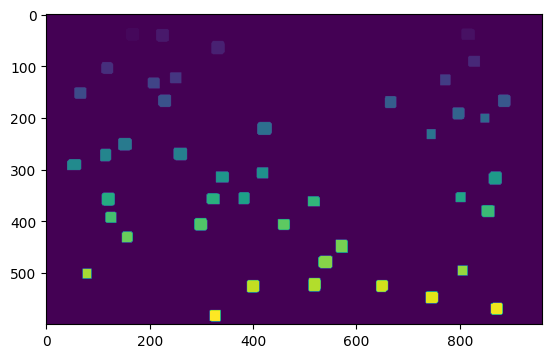

In [83]:
import scipy
from scipy import ndimage
import matplotlib.pyplot as plt
im = mask_soft[1,:]

# smooth and threshold as image has compression artifacts (jpg)
im = ndimage.gaussian_filter(im, 2)
# im[im<10]=0
blobs, number_of_blobs = ndimage.label(im)
print(number_of_blobs)

plt.imshow(blobs)


50
61


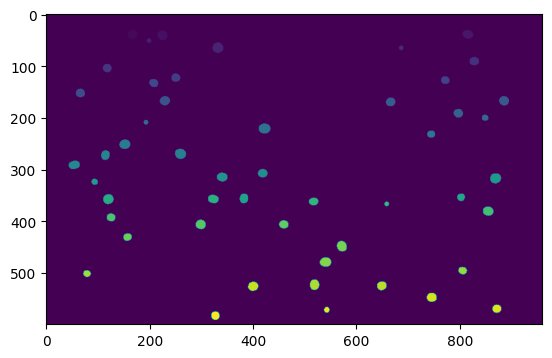

In [80]:
im = mask_pred_1*255

# smooth and threshold as image has compression artifacts (jpg)
im = ndimage.gaussian_filter(im, 2)
# im[im<10]=0
blobs, number_of_blobs = ndimage.label(im)
print(number_of_blobs)
plt.imshow(blobs)



np.unique(mask_pred_1)
mask_pred_1.sum()/ len(np.unique(blobs))
np.unique(blobs)

l = []
for i in range(51):    
    reg = np.zeros((blobs.shape))
    reg = blobs== i #np.where(blobs== i, 1, 0)

    # print(reg.sum())
    l.append(reg.sum())



print(np.asarray(l).min())

39


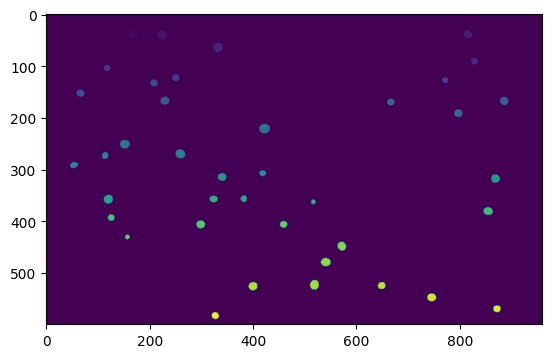

In [17]:
im = (1-mask_pred_0)*255

# smooth and threshold as image has compression artifacts (jpg)
im = ndimage.gaussian_filter(im, 2)
# im[im<10]=0
blobs, number_of_blobs = ndimage.label(im)
print(number_of_blobs)
plt.imshow(blobs)